<a href="https://colab.research.google.com/github/CaptainAshis/Time_Series_Python-SQL/blob/master/TimeSeries5_SArimax_exogenous.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:

import glob, re
import numpy as np
import pandas as pd
from sklearn import *
from datetime import datetime
from xgboost import XGBRegressor

In [0]:

import matplotlib.pyplot as plt

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
 %cd drive/'My Drive'/amex/Restaurant

/content/drive/My Drive/amex/Restaurant


In [0]:
# !curl --header 'Host: storage.googleapis.com' --user-agent 'Mozilla/5.0 (Windows NT 6.3; Win64; x64; rv:67.0) Gecko/20100101 Firefox/67.0' --header 'Accept: text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8' --header 'Accept-Language: en-US,en;q=0.5' --referer 'https://www.kaggle.com/' --header 'Upgrade-Insecure-Requests: 1' 'https://storage.googleapis.com/kaggle-competitions-data/kaggle/7277/all.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1562343986&Signature=YDjv%2B9DKBzWtZYPk8FQ8CARDvLT8OTSNuxLeKEA592PxQrnogPSttkBfsQXO9hapY2P6kVGqhlSK6jGGQqFQCFEMqldWLGiYmHHSAV4%2BGe0T4haVHKaGbBeXXLqEB8pre1mM7rPt9C3DdCAxcCVnRhI%2F2wroP0%2F%2BYu%2FnXBJSP8Qnkr2ep%2BZYVdXHrtTAs4%2FsZYyitp0ZS87Hl%2B2bBMXEwxaBLPPtPwyiM5VL0uPezTyb39chIZQiYLkuMPVuVVQ63N%2BzlXtNMrHjg6iJwOQppYaKZbg31K8V3g9u9FW%2B5ehhuy%2F20tE6%2B0AYPYkn49ivKYYft8GSZyfKxIyjccWi5w%3D%3D&response-content-disposition=attachment%3B+filename%3Drecruit-restaurant-visitor-forecasting.zip' --output 'recruit-restaurant-visitor-forecasting.zip'

In [0]:
# !unzip recruit-restaurant-visitor-forecasting.zip

In [0]:
def RMSLE(y, pred):
    return metrics.mean_squared_error(y, pred)**0.5

def plot_actual_predicted(actual, predicted):
    print('RMSE: ', RMSLE(actual, predicted))
    tmp = pd.DataFrame({'actual': actual, 'predicted': predicted}).sort_values(['actual'])
    plt.scatter(range(tmp.shape[0]), tmp['predicted'], color='green')
    plt.scatter(range(tmp.shape[0]), tmp['actual'], color='blue')
    plt.show()
    del tmp

In [0]:
ls

air_reserve.csv     hpg_store_info.csv
air_store_info.csv  recruit-restaurant-visitor-forecasting.zip
air_visit_data.csv  sample_submission.csv
date_info.csv       store_id_relation.csv
hpg_reserve.csv


In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import *
from datetime import datetime
import calendar
# 
air = pd.read_csv('air_visit_data.csv', parse_dates=[1])
air.set_index(['visit_date'], inplace=True)
air.index.name=None
air.drop('air_store_id',axis=1,inplace=True)
df2=pd.DataFrame()
df2['visit_total'] = air.groupby(air.index,squeeze=True,sort=True)['visitors'].sum()
df2['visit_mean'] = air.groupby(air.index,squeeze=True,sort=True)['visitors'].mean()
df2['reserv_cnt'] = air.groupby(air.index,squeeze=True,sort=True)['visitors'].count()
air=df2;del df2

#Get the date info with dow and holidays
hol=pd.read_csv('date_info.csv', parse_dates=True).rename(columns={'calendar_date':'visit_date'})
hol['visit_date'] = pd.to_datetime(hol['visit_date'])
hol.set_index(['visit_date'], inplace=True)
hol.index.name=None
hol.day_of_week = hol.day_of_week.apply(list(calendar.day_name).index)

#Get the test submission
test = pd.read_csv('sample_submission.csv')
test['store_id'], test['visit_date'] = test['id'].str[:20], test['id'].str[21:]
test.set_index('visit_date', drop=True, inplace=True)
test.index.name=None

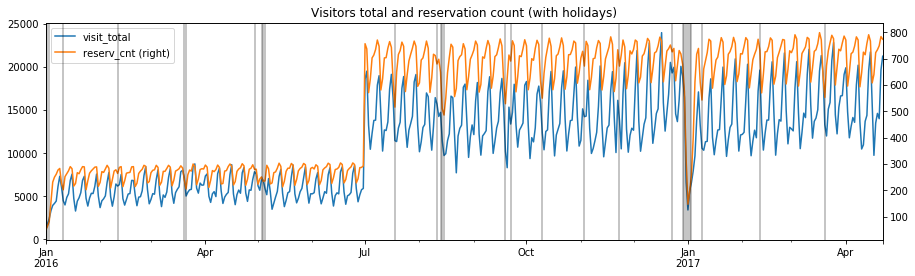

In [0]:
#Plot the cumulative visits
air['visit_total'].plot(legend=True);
air['reserv_cnt'].plot(legend=True, figsize=(15,4), secondary_y=True,
                      title='Visitors total and reservation count (with holidays)');
for x in hol.query('holiday_flg==1').index:
    _ = plt.axvline(x=x, color='k', alpha = 0.3);

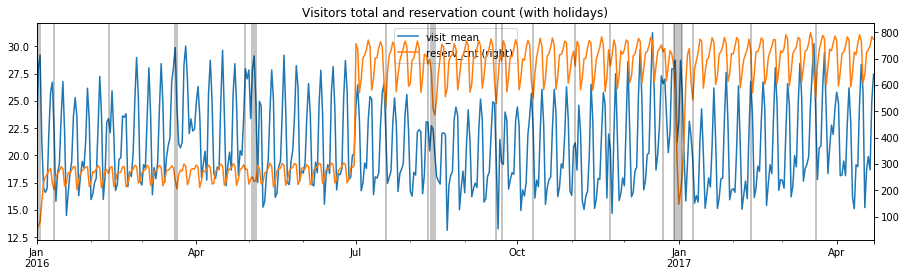

In [0]:
air['visit_mean'].plot(figsize=(15,4), legend=True, title='Visitors mean (with holidays)')
air['reserv_cnt'].plot(legend=True, figsize=(15,4), secondary_y=True, title='Visitors total and reservation count (with holidays)');
for x in hol.query('holiday_flg==1').index:
    _ = plt.axvline(x=x, color='k', alpha = 0.3);

<Figure size 432x288 with 0 Axes>

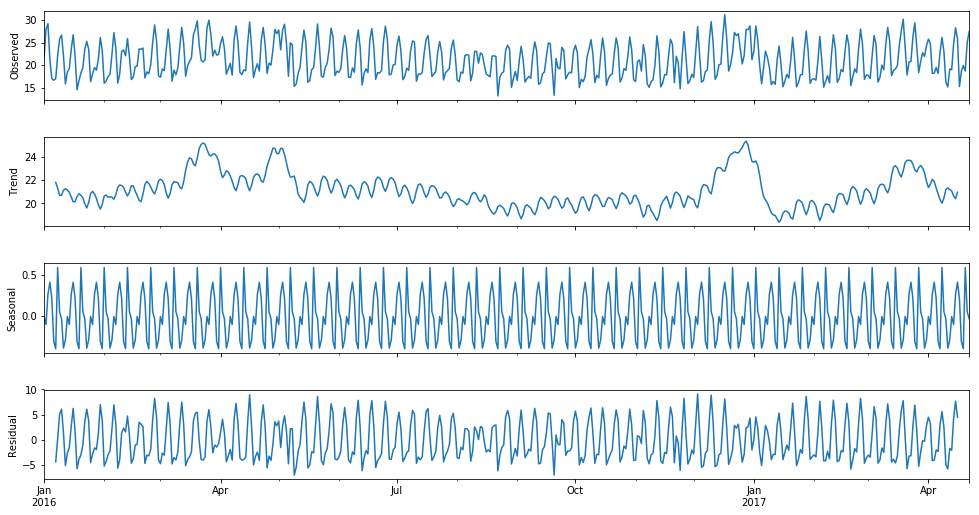

In [0]:
import statsmodels.api as sm  
from statsmodels.tsa.stattools import acf  
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(air.visit_mean, freq=12)  
fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(15, 8)

In [0]:
df2=air.join(hol)
df2[df2.holiday_flg==0].groupby(hol.day_of_week,squeeze=True,sort=True)['visit_mean'].sum()
#df2.day_of_week=df3.day_of_week.apply(lambda x: list(calendar.day_name)[x]) # equiv to air.sum(0)

day_of_week
0     990.358277
1    1166.228003
2    1265.651637
3    1162.836395
4    1503.191793
5    1731.514759
6    1534.474447
Name: visit_mean, dtype: float64

In [0]:
df2.head()

,visit_total,visit_mean,reserv_cnt,day_of_week,holiday_flg
2016-01-01,1033,21.520833,48,4,1
2016-01-02,1764,28.000000,63,5,1
2016-01-03,2368,29.234568,81,6,1
2016-01-04,3326,21.184713,157,0,0
2016-01-05,3927,17.000000,231,1,0


In [0]:
df2.index.freq='D'

In [0]:
df2.tail()

,visit_total,visit_mean,reserv_cnt,day_of_week,holiday_flg
2017-04-18,13489,18.656985,723,1,0
2017-04-19,14607,19.900545,734,2,0
2017-04-20,13990,18.678238,749,3,0
2017-04-21,19624,25.030612,784,4,0
2017-04-22,21245,27.448320,774,5,0


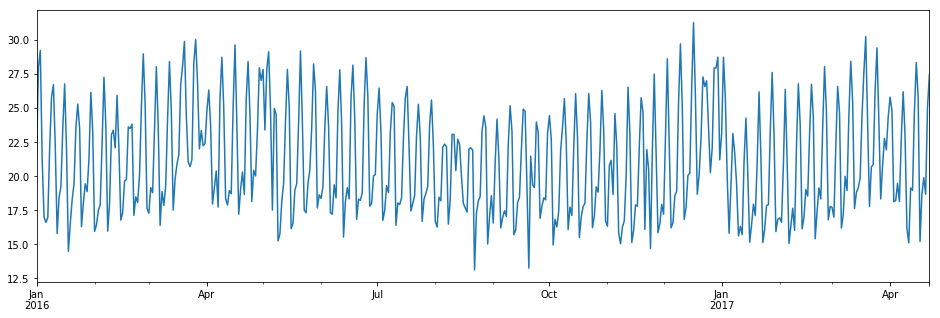

In [0]:
df2['visit_mean'].plot(figsize=(16,5))

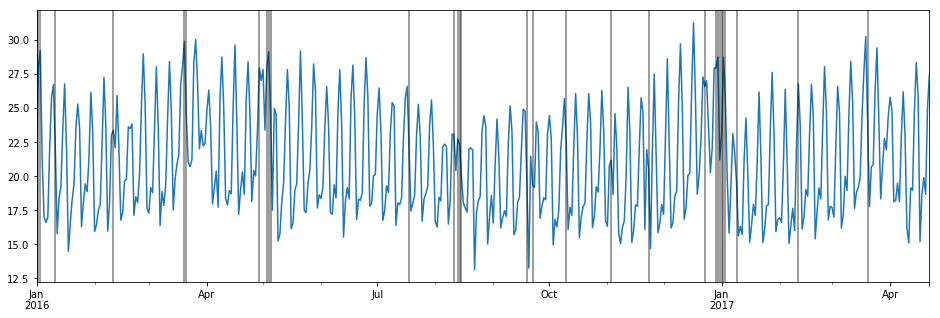

In [0]:
ax=df2['visit_mean'].plot(figsize=(16,5))
for day in df2.query('holiday_flg==1').index:
  ax.axvline(x=day,color='black',alpha=0.5);
  
  

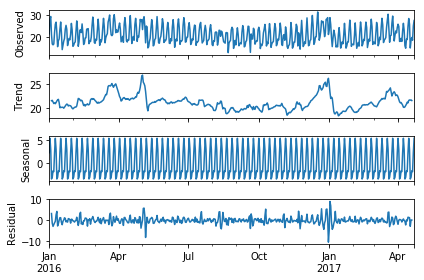

In [0]:
from statsmodels.tsa.seasonal import seasonal_decompose
result=seasonal_decompose(df2['visit_mean'])
result.plot();

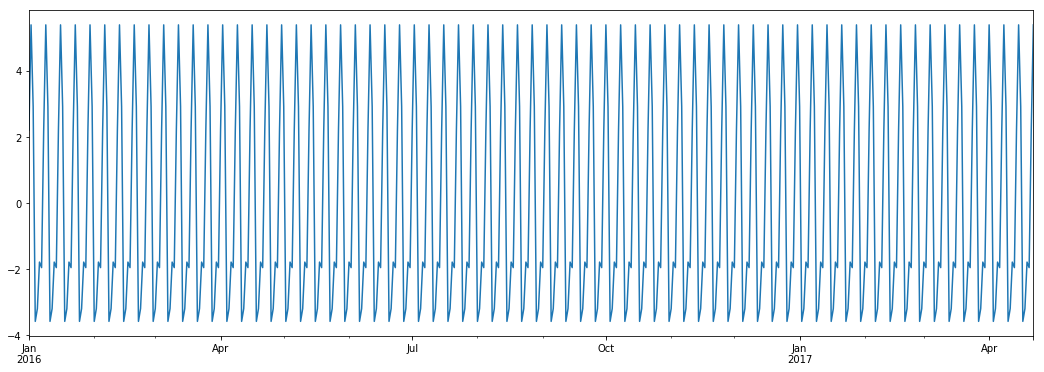

In [0]:
result.seasonal.plot(figsize=(18,6))

In [0]:
print(len(df2))
train=df2.iloc[:436]
test=df2.iloc[436:]

478


In [0]:
!pip install pmdarima

     |████████████████████████████████| 921kB 5.1MB/s 
     |████████████████████████████████| 24.8MB 1.3MB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: scipy 1.3.0
    Uninstalling scipy-1.3.0:
      Successfully uninstalled scipy-1.3.0


In [0]:
from pmdarima import auto_arima

In [0]:
auto_arima(df2['visit_mean'],seasonal=True,m=7).summary()

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertib

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                                 y   No. Observations:                  478
Model:             SARIMAX(1, 1, 2)x(2, 0, 1, 7)   Log Likelihood                -987.745
Date:                           Wed, 03 Jul 2019   AIC                           1991.490
Time:                                   01:18:05   BIC                           2024.830
Sample:                                        0   HQIC                          2004.598
                                           - 478                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -3.658e-06   9.81e-06     -0.373      0.709   -2.29e-05    1.56e-05
ar.L1          0.2155      0.061      3.533      0.000       0.096       0.335
ma.L1         -0.6186      0.057    -10.911      0.000      -0.730      -0.507
ma.L2         -0.3789      0.056     -6.755      0.000      -0.489      -0.269
ar.S.L7        1.2079      0.064     18.867      0.000       1.082       1.333
ar.S.L14      -0.2100      0.063     -3.354      0.001      -0.333      -0.087
ma.S.L7       -0.9107      0.046    -19.597      0.000      -1.002      -0.820
sigma2         3.5469      0.170     20.851      0.000       3.214       3.880
===================================================================================
Ljung-Box (Q):                       57.08   Jarque-Bera (JB):               229.62
Prob(Q):                              0.04   Prob(JB):                         0.00
Heteroskedasticity (H):               1.15   Skew:                             0.28
Prob(H) (two-sided):                  0.39   Kurtosis:                         6.35
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [0]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [0]:
model=SARIMAX(train['visit_mean'],order=(1,0,0),seasonal_order=(2,0,0,7),enforce_invertibility=False)

In [0]:
results=model.fit()

In [0]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                        visit_mean   No. Observations:                  436
Model:             SARIMAX(1, 0, 0)x(2, 0, 0, 7)   Log Likelihood                -976.635
Date:                           Wed, 03 Jul 2019   AIC                           1961.269
Time:                                   01:18:06   BIC                           1977.580
Sample:                               01-01-2016   HQIC                          1967.706
                                    - 03-11-2017                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5031      0.031     16.382      0.000       0.443       0.563
ar.S.L7        0.6097      0.033     18.729      0.000       0.546       0.673
ar.S.L14       0.3760      0.033     11.562      0.000       0.312       0.440
sigma2         4.8885      0.209     23.362      0.000       4.478       5.299
===================================================================================
Ljung-Box (Q):                      125.82   Jarque-Bera (JB):               240.96
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.05   Skew:                            -0.52
Prob(H) (two-sided):                  0.79   Kurtosis:                         6.49
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [0]:
start=len(train)
end=len(train)+len(test)-1
print(start),print(end)
predictions=results.predict(start,end).rename('SARIMA Model')

436
477


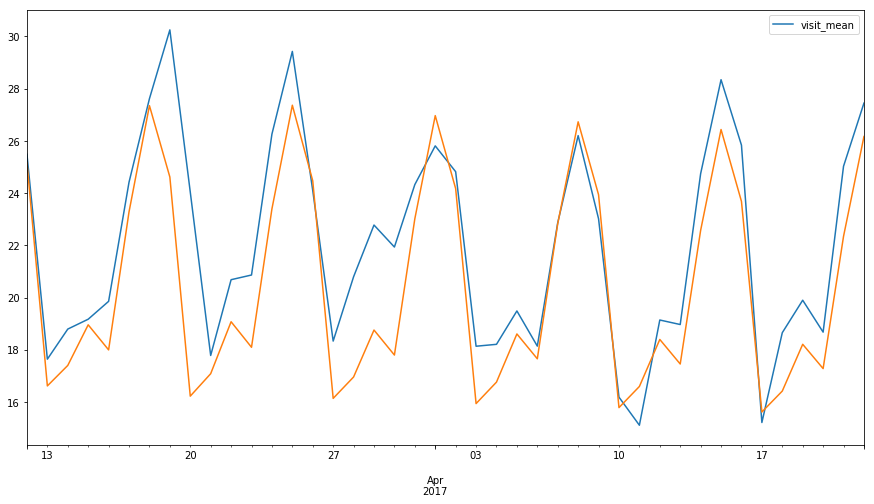

In [0]:
test['visit_mean'].plot(legend=True,figsize=(15,8))
predictions.plot()

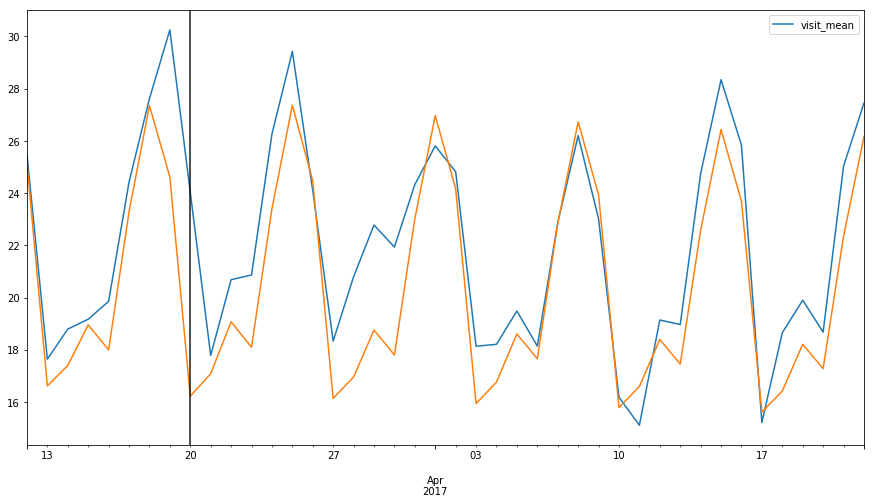

In [0]:
ax=test['visit_mean'].plot(legend=True,figsize=(15,8))
predictions.plot()

# ax=df2['visit_mean'].plot(figsize=(16,5))
for day in test.query('holiday_flg==1').index:
  ax.axvline(x=day,color='black',alpha=0.9);
  
  

In [0]:
 from statsmodels.tools.eval_measures import rmse

In [0]:
rmse(test['visit_mean'],predictions)


2.322078215077344

# **Exogeneous**

In [0]:
df2.columns

Index(['visit_total', 'visit_mean', 'reserv_cnt', 'day_of_week',
       'holiday_flg'],
      dtype='object')

In [0]:
auto_arima(df2['visit_mean'],exogenous=df2[['holiday_flg']],seasonal=True,m=7).summary()

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertib

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                                 y   No. Observations:                  478
Model:             SARIMAX(0, 1, 3)x(2, 0, 2, 7)   Log Likelihood                -945.426
Date:                           Wed, 03 Jul 2019   AIC                           1910.852
Time:                                   01:19:51   BIC                           1952.527
Sample:                                        0   HQIC                          1927.238
                                           - 478                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   4.247e-05      0.000      0.121      0.904      -0.001       0.001
x1             3.2450      0.270     12.030      0.000       2.716       3.774
ma.L1         -0.4360      0.048     -9.117      0.000      -0.530      -0.342
ma.L2         -0.4036      0.046     -8.771      0.000      -0.494      -0.313
ma.L3         -0.0721      0.034     -2.145      0.032      -0.138      -0.006
ar.S.L7        0.1054      0.397      0.265      0.791      -0.673       0.883
ar.S.L14       0.8906      0.396      2.251      0.024       0.115       1.666
ma.S.L7       -0.0015      0.376     -0.004      0.997      -0.738       0.735
ma.S.L14      -0.8234      0.332     -2.480      0.013      -1.474      -0.173
sigma2         2.9936      0.140     21.377      0.000       2.719       3.268
===================================================================================
Ljung-Box (Q):                       62.15   Jarque-Bera (JB):               591.27
Prob(Q):                              0.01   Prob(JB):                         0.00
Heteroskedasticity (H):               1.59   Skew:                            -0.25
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.43
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [0]:
model=SARIMAX(train['visit_mean'],exog=train[['holiday_flg']],order=(1,0,1),seasonal_order=(1,0,1,7),enforce_invertibility=False)
result=model.fit()
result.summary()

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                        visit_mean   No. Observations:                  436
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 7)   Log Likelihood                -904.489
Date:                           Wed, 03 Jul 2019   AIC                           1820.977
Time:                                   01:19:53   BIC                           1845.443
Sample:                               01-01-2016   HQIC                          1830.633
                                    - 03-11-2017                                         
Covariance Type:                             opg                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
holiday_flg     3.7562      0.220     17.072      0.000       3.325       4.187
ar.L1           0.9985      0.002    619.102      0.000       0.995       1.002
ma.L1          -1.2379      0.032    -38.888      0.000      -1.300      -1.176
ar.S.L7         0.9995      0.001   1551.610      0.000       0.998       1.001
ma.S.L7        -1.0474      0.032    -32.636      0.000      -1.110      -0.984
sigma2          2.0603      0.125     16.443      0.000       1.815       2.306
===================================================================================
Ljung-Box (Q):                      179.24   Jarque-Bera (JB):               966.32
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.35   Skew:                            -0.82
Prob(H) (two-sided):                  0.07   Kurtosis:                        10.10
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [0]:
start=len(train)
end=len(train)+len(test)-1
print(start),print(end)
predictions=results.predict(start,end,exog=test[['holiday_flg']]).rename('SARIMAX Model with exogeneous')


436
477


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:1935: ValueWarning: Exogenous array provided to predict, but additional data not required. `exog` argument ignored.
  ' required. `exog` argument ignored.', ValueWarning)


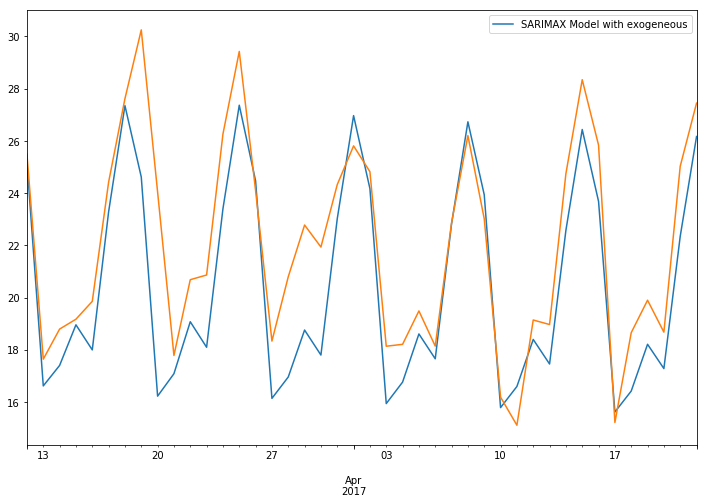

In [0]:
predictions.plot(figsize=(12,8),legend=True)
test['visit_mean'].plot()

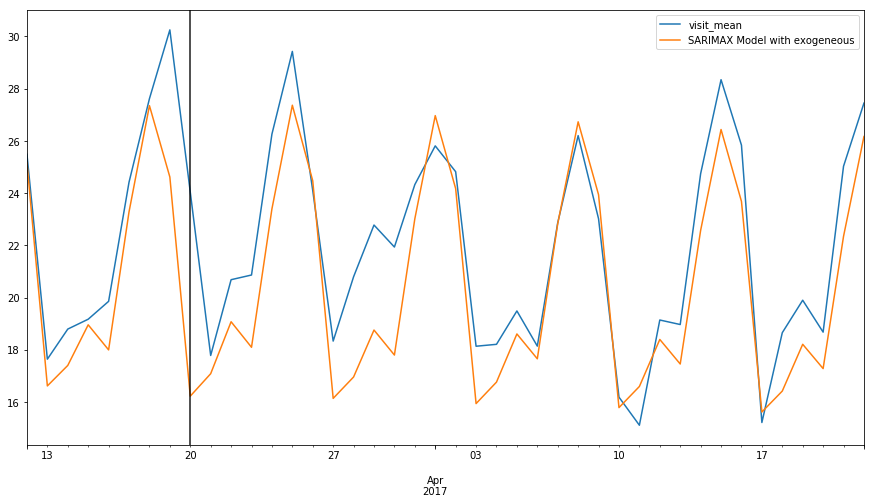

In [0]:
ax=test['visit_mean'].plot(legend=True,figsize=(15,8))
predictions.plot(legend=True)

# ax=df2['visit_mean'].plot(figsize=(16,5))
for day in test.query('holiday_flg==1').index:
  ax.axvline(x=day,color='black',alpha=0.9);
  
  

In [0]:
rmse(test['visit_mean'],predictions)


2.322078215077344

We will go with ARIMAX with exogeneous variable.

In [0]:
model=SARIMAX(df2['visit_mean'],exog=df2[['holiday_flg']],order=(1,0,1),seasonal_order=(1,0,1,7),enforce_invertibility=False)
result=model.fit()
result.summary()

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                        visit_mean   No. Observations:                  478
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 7)   Log Likelihood                -981.460
Date:                           Wed, 03 Jul 2019   AIC                           1974.921
Time:                                   01:19:56   BIC                           1999.938
Sample:                               01-01-2016   HQIC                          1984.756
                                    - 04-22-2017                                         
Covariance Type:                             opg                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
holiday_flg     3.7565      0.214     17.560      0.000       3.337       4.176
ar.L1           0.9972      0.003    328.197      0.000       0.991       1.003
ma.L1          -0.7964      0.020    -39.314      0.000      -0.836      -0.757
ar.S.L7         0.9998      0.000   2659.826      0.000       0.999       1.001
ma.S.L7        -0.9690      0.032    -30.252      0.000      -1.032      -0.906
sigma2          3.3299      0.138     24.104      0.000       3.059       3.601
===================================================================================
Ljung-Box (Q):                      180.42   Jarque-Bera (JB):              1049.77
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.46   Skew:                            -0.74
Prob(H) (two-sided):                  0.02   Kurtosis:                        10.11
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [0]:
len(df2)

478

In [0]:
exog_forecast=df2[436:][['holiday_flg']]

In [0]:
len(exog_forecast)

42

In [0]:
# start=len(train)
# end=len(train)+len(test)-1
# print(start),print(end)
fcast=results.predict(len(df2),len(df2)+42,exog=exog_forecast).rename('FINAL SARIMAX Model FORECAST exogeneous')

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:1935: ValueWarning: Exogenous array provided to predict, but additional data not required. `exog` argument ignored.
  ' required. `exog` argument ignored.', ValueWarning)


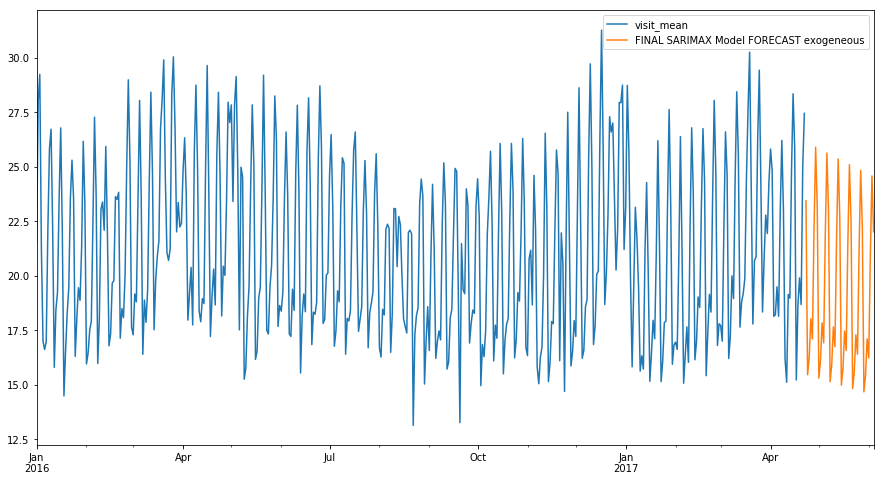

In [0]:
df2['visit_mean'].plot(figsize=(15,8),legend=True)
fcast.plot(legend=True)

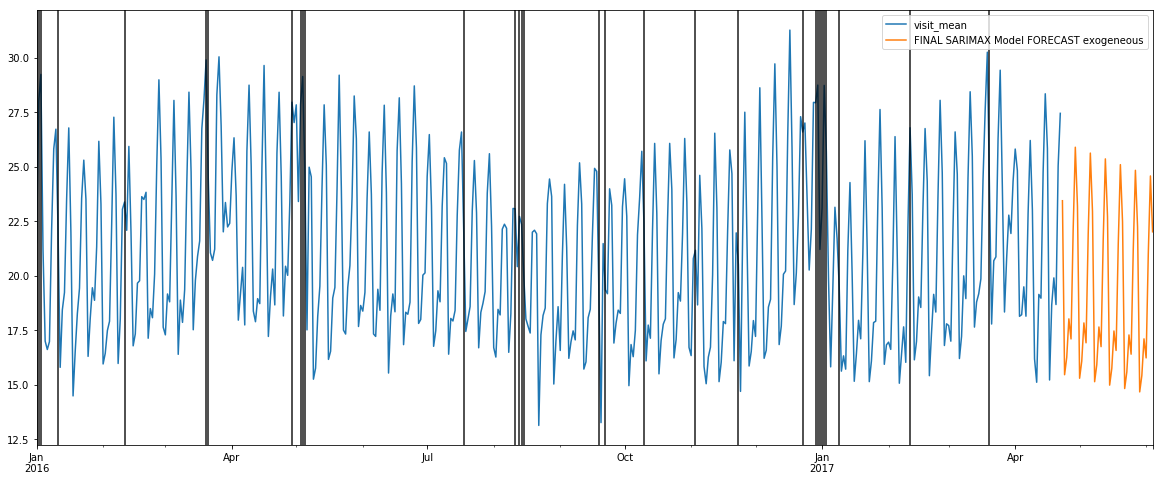

In [0]:
ax=df2['visit_mean'].plot(legend=True,figsize=(20,8))
fcast.plot(legend=True)

# ax=df2['visit_mean'].plot(figsize=(16,5))
for day in df2.query('holiday_flg==1').index:
  ax.axvline(x=day,color='black',alpha=0.9);
  
  

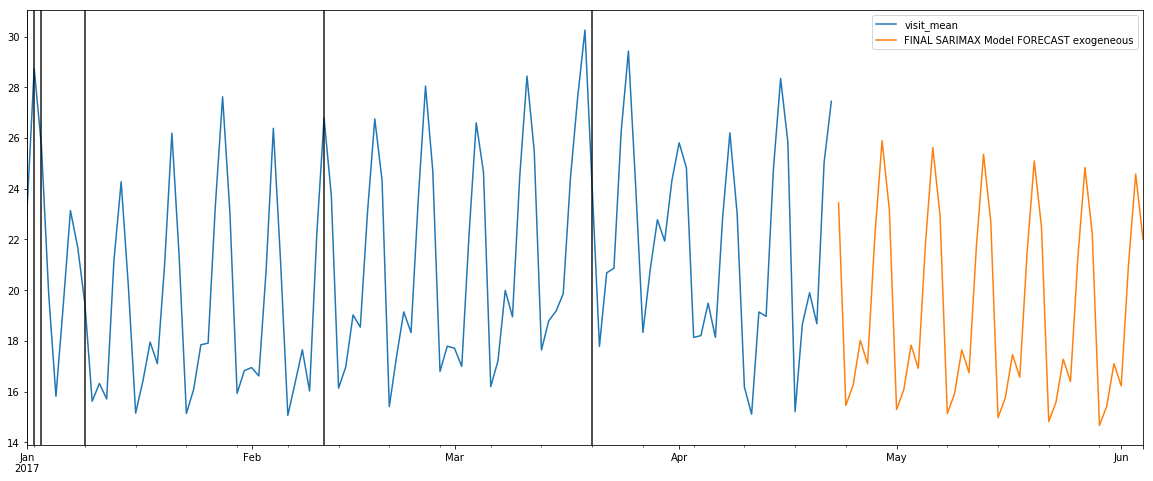

In [0]:
ax=df2['visit_mean'].loc['2017-01-01':].plot(legend=True,figsize=(20,8))
fcast.plot(legend=True)

# ax=df2['visit_mean'].plot(figsize=(16,5))
for day in df2.query('holiday_flg==1').index:
  ax.axvline(x=day,color='black',alpha=0.9);
  
  